In [1]:
import torch
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import re, magic

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage import zoom
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

#vit
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import os

In [2]:
#for whole inference (without label)
test_imgs = os.listdir('/home/super/endo_venv/gsun/blur_classification/inferenced_data/clean/')

In [3]:
print(len(test_imgs))

2055


In [4]:
print(test_imgs[:10])

['V1492_2021_0042_002196.png', 'V1492_2021_0042_000279.png', 'V1492_2021_0042_003584.png', 'V1492_2021_0042_002230.png', 'V1492_2021_0042_000013.png', 'V1492_2021_0042_004370.png', 'V1492_2021_0042_003993.png', 'V1492_2021_0042_000096.png', 'V1492_2021_0042_004724.png', 'V1492_2021_0042_000993.png']


In [3]:
#for inference with labeled data
true_imgs = os.listdir('/Data/data/data_gsun/data/cecum/cecum_test_frames/cecum/')

false_imgs = os.listdir('/Data/data/data_gsun/data/cecum/cecum_test_frames/non_cecum/')

In [4]:
print(len(true_imgs))

465


In [5]:
print(true_imgs[:10])

['V0246_2020_0016_001613.png', 'V0246_2020_0016_001435.png', 'V0246_2020_0016_001430.png', 'V0246_2020_0016_001425.png', 'V0244_2020_0014_001780.png', 'V0244_2020_0014_001709.png', 'V0242_2020_0012_002368.png', 'V0242_2020_0012_002363.png', 'V0242_2020_0012_002064.png', 'V0242_2020_0012_002021.png']


In [6]:
#for whole inference (without label)
df_test = pd.DataFrame(columns = ['image_id'])

In [7]:
df_test['image_id'] = test_imgs

NameError: name 'test_imgs' is not defined

In [8]:
df_test['image_id'] = df_test['image_id'].apply(lambda x: '/clean/' + x)

In [8]:
df_test.head(3)

,image_id
0,/clean/V1492_2021_0042_002196.png
1,/clean/V1492_2021_0042_000279.png
2,/clean/V1492_2021_0042_003584.png


In [6]:
#for inference with labeled data
df_true = pd.DataFrame(columns = ['image_id', 'label'])

In [7]:
df_true['image_id'] = true_imgs
df_true['label'] = 1

In [8]:
df_true['image_id'] = df_true['image_id'].apply(lambda x: '/cecum/' + x)

In [9]:
df_true.head(3)

,image_id,label
0,/cecum/V0246_2020_0016_001613.png,1
1,/cecum/V0246_2020_0016_001435.png,1
2,/cecum/V0246_2020_0016_001430.png,1


In [10]:
df_false = pd.DataFrame(columns = ['image_id', 'label'])

In [11]:
df_false['image_id'] = false_imgs
df_false['label'] = 0

In [12]:
df_false['image_id'] = df_false['image_id'].apply(lambda x: '/non_cecum/' + x)

In [13]:
df_false.head(3)

,image_id,label
0,/non_cecum/V0681_3_TC_00753.png,0
1,/non_cecum/V0681_3_TC_00538.png,0
2,/non_cecum/V0318_3_TC_00743.png,0


In [14]:
df_test = pd.concat([df_true, df_false], axis = 0)

In [15]:
df_test.head(3)

,image_id,label
0,/cecum/V0246_2020_0016_001613.png,1
1,/cecum/V0246_2020_0016_001435.png,1
2,/cecum/V0246_2020_0016_001430.png,1


In [16]:
df_test.shape

(2325, 2)

In [17]:
test = df_test.copy()

In [18]:
test.shape

(2325, 2)

In [19]:
test.head(3)

,image_id,label
0,/cecum/V0246_2020_0016_001613.png,1
1,/cecum/V0246_2020_0016_001435.png,1
2,/cecum/V0246_2020_0016_001430.png,1


In [20]:
test.tail(3)

,image_id,label
1857,/non_cecum/V0681_6_Rectum_00013.png,0
1858,/non_cecum/V0548_6_Rectum_00139.png,0
1859,/non_cecum/V0259_6_Rectum_00013.png,0


In [27]:
%run classification_inference_efficientnet.ipynb

100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:12<00:00, 18.84it/s]


In [127]:
#model performance check by epoch
test_dir = '/Data/data/data_gsun/data/cecum/cecum_test_frames'

list_models = os.listdir('efficientnet_lite0/')
# list_models = os.listdir('8th_epoch_11/')
list_models = sorted(list_models)
box_acc = []
box_conf = []
for i,model in enumerate(list_models):
    print(model, i)
    perf = []
    model_dir = 'efficientnet_lite0/' + model
#     model_dir = '8th_epoch_11/' + model
    %run classification_inference_efficientnet.ipynb
    
    test['pred'] = np.argmax(tst_preds, axis=1)
    test_acc = np.sum(test.label == test.pred) / len(test)
    test_matrix = confusion_matrix(test['label'], test['pred'])
    box_acc.append(test_acc)
    box_conf.append(test_matrix)
    
    print(test_acc)
    print(test_matrix)
    print('---------------------------------------')


20%_drop_efficientnet_lite0_0 0


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:12<00:00, 18.02it/s]


0.7204301075268817
[[1221  639]
 [  11  454]]
---------------------------------------
20%_drop_efficientnet_lite0_1 1


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.75it/s]


0.7363440860215054
[[1251  609]
 [   4  461]]
---------------------------------------
20%_drop_efficientnet_lite0_10 2


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.94it/s]


0.6387096774193548
[[1044  816]
 [  24  441]]
---------------------------------------
20%_drop_efficientnet_lite0_11 3


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.78it/s]


0.6167741935483871
[[983 877]
 [ 14 451]]
---------------------------------------
20%_drop_efficientnet_lite0_12 4


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.81it/s]


0.5767741935483871
[[898 962]
 [ 22 443]]
---------------------------------------
20%_drop_efficientnet_lite0_13 5


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.86it/s]


0.7608602150537634
[[1339  521]
 [  35  430]]
---------------------------------------
20%_drop_efficientnet_lite0_14 6


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.73it/s]


0.5341935483870968
[[ 780 1080]
 [   3  462]]
---------------------------------------
20%_drop_efficientnet_lite0_15 7


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.68it/s]


0.6701075268817205
[[1120  740]
 [  27  438]]
---------------------------------------
20%_drop_efficientnet_lite0_16 8


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.09it/s]


0.5552688172043011
[[ 832 1028]
 [   6  459]]
---------------------------------------
20%_drop_efficientnet_lite0_17 9


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.02it/s]


0.5853763440860215
[[924 936]
 [ 28 437]]
---------------------------------------
20%_drop_efficientnet_lite0_18 10


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.86it/s]


0.6098924731182795
[[964 896]
 [ 11 454]]
---------------------------------------
20%_drop_efficientnet_lite0_19 11


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.07it/s]


0.6438709677419355
[[1041  819]
 [   9  456]]
---------------------------------------
20%_drop_efficientnet_lite0_2 12


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.75it/s]


0.7316129032258064
[[1247  613]
 [  11  454]]
---------------------------------------
20%_drop_efficientnet_lite0_20 13


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.60it/s]


0.7462365591397849
[[1306  554]
 [  36  429]]
---------------------------------------
20%_drop_efficientnet_lite0_21 14


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.74it/s]


0.6219354838709678
[[989 871]
 [  8 457]]
---------------------------------------
20%_drop_efficientnet_lite0_22 15


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.89it/s]


0.7548387096774194
[[1297  563]
 [   7  458]]
---------------------------------------
20%_drop_efficientnet_lite0_23 16


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.71it/s]


0.7961290322580645
[[1417  443]
 [  31  434]]
---------------------------------------
20%_drop_efficientnet_lite0_24 17


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.66it/s]


0.610752688172043
[[965 895]
 [ 10 455]]
---------------------------------------
20%_drop_efficientnet_lite0_25 18


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.95it/s]


0.4989247311827957
[[ 699 1161]
 [   4  461]]
---------------------------------------
20%_drop_efficientnet_lite0_26 19


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.81it/s]


0.5105376344086021
[[ 734 1126]
 [  12  453]]
---------------------------------------
20%_drop_efficientnet_lite0_27 20


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.03it/s]


0.6335483870967742
[[1036  824]
 [  28  437]]
---------------------------------------
20%_drop_efficientnet_lite0_28 21


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.96it/s]


0.5827956989247312
[[908 952]
 [ 18 447]]
---------------------------------------
20%_drop_efficientnet_lite0_29 22


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.78it/s]


0.6627956989247312
[[1109  751]
 [  33  432]]
---------------------------------------
20%_drop_efficientnet_lite0_3 23


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.05it/s]


0.7574193548387097
[[1307  553]
 [  11  454]]
---------------------------------------
20%_drop_efficientnet_lite0_30 24


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.93it/s]


0.6748387096774193
[[1183  677]
 [  79  386]]
---------------------------------------
20%_drop_efficientnet_lite0_31 25


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.86it/s]


0.5264516129032258
[[ 798 1062]
 [  39  426]]
---------------------------------------
20%_drop_efficientnet_lite0_32 26


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.03it/s]


0.64
[[1071  789]
 [  48  417]]
---------------------------------------
20%_drop_efficientnet_lite0_33 27


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.91it/s]


0.7156989247311828
[[1236  624]
 [  37  428]]
---------------------------------------
20%_drop_efficientnet_lite0_34 28


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.84it/s]


0.629247311827957
[[1015  845]
 [  17  448]]
---------------------------------------
20%_drop_efficientnet_lite0_35 29


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.15it/s]


0.6589247311827957
[[1089  771]
 [  22  443]]
---------------------------------------
20%_drop_efficientnet_lite0_36 30


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.97it/s]


0.7858064516129032
[[1395  465]
 [  33  432]]
---------------------------------------
20%_drop_efficientnet_lite0_37 31


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.99it/s]


0.7294623655913979
[[1259  601]
 [  28  437]]
---------------------------------------
20%_drop_efficientnet_lite0_38 32


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.06it/s]


0.5548387096774193
[[ 827 1033]
 [   2  463]]
---------------------------------------
20%_drop_efficientnet_lite0_39 33


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.88it/s]


0.6541935483870968
[[1067  793]
 [  11  454]]
---------------------------------------
20%_drop_efficientnet_lite0_4 34


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.73it/s]


0.7737634408602151
[[1355  505]
 [  21  444]]
---------------------------------------
20%_drop_efficientnet_lite0_40 35


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.80it/s]


0.6993548387096774
[[1182  678]
 [  21  444]]
---------------------------------------
20%_drop_efficientnet_lite0_41 36


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.67it/s]


0.7023655913978495
[[1188  672]
 [  20  445]]
---------------------------------------
20%_drop_efficientnet_lite0_42 37


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.94it/s]


0.5440860215053763
[[ 806 1054]
 [   6  459]]
---------------------------------------
20%_drop_efficientnet_lite0_43 38


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.78it/s]


0.7002150537634408
[[1168  692]
 [   5  460]]
---------------------------------------
20%_drop_efficientnet_lite0_44 39


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.99it/s]


0.6597849462365591
[[1085  775]
 [  16  449]]
---------------------------------------
20%_drop_efficientnet_lite0_45 40


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.91it/s]


0.6679569892473118
[[1102  758]
 [  14  451]]
---------------------------------------
20%_drop_efficientnet_lite0_46 41


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.86it/s]


0.704516129032258
[[1212  648]
 [  39  426]]
---------------------------------------
20%_drop_efficientnet_lite0_47 42


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.94it/s]


0.7389247311827957
[[1272  588]
 [  19  446]]
---------------------------------------
20%_drop_efficientnet_lite0_48 43


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.07it/s]


0.6640860215053763
[[1092  768]
 [  13  452]]
---------------------------------------
20%_drop_efficientnet_lite0_49 44


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 20.06it/s]


0.6262365591397849
[[1004  856]
 [  13  452]]
---------------------------------------
20%_drop_efficientnet_lite0_5 45


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.67it/s]


0.6012903225806452
[[943 917]
 [ 10 455]]
---------------------------------------
20%_drop_efficientnet_lite0_6 46


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.84it/s]


0.6438709677419355
[[1039  821]
 [   7  458]]
---------------------------------------
20%_drop_efficientnet_lite0_7 47


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.79it/s]


0.6498924731182796
[[1056  804]
 [  10  455]]
---------------------------------------
20%_drop_efficientnet_lite0_8 48


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.82it/s]


0.535483870967742
[[ 785 1075]
 [   5  460]]
---------------------------------------
20%_drop_efficientnet_lite0_9 49


100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:11<00:00, 19.92it/s]

0.730752688172043
[[1281  579]
 [  47  418]]
---------------------------------------


In [128]:
print(max(box_acc), box_acc.index(max(box_acc)))

0.7961290322580645 16


In [126]:
for i,e in enumerate(box_acc):
    print(i, e, '\n', box_conf[i])

0 0.7445161290322581 
 [[1304  556]
 [  38  427]]
1 0.7359139784946237 
 [[1263  597]
 [  17  448]]
2 0.5324731182795699 
 [[ 779 1081]
 [   6  459]]
3 0.6365591397849463 
 [[1020  840]
 [   5  460]]
4 0.6103225806451613 
 [[972 888]
 [ 18 447]]
5 0.6305376344086021 
 [[1010  850]
 [   9  456]]
6 0.6365591397849463 
 [[1025  835]
 [  10  455]]
7 0.7832258064516129 
 [[1393  467]
 [  37  428]]
8 0.7604301075268817 
 [[1397  463]
 [  94  371]]
9 0.8473118279569892 
 [[1527  333]
 [  22  443]]
10 0.704516129032258 
 [[1184  676]
 [  11  454]]
11 0.6116129032258064 
 [[973 887]
 [ 16 449]]
12 0.6640860215053763 
 [[1098  762]
 [  19  446]]
13 0.5604301075268817 
 [[ 845 1015]
 [   7  458]]
14 0.7845161290322581 
 [[1392  468]
 [  33  432]]
15 0.6163440860215054 
 [[980 880]
 [ 12 453]]
16 0.6159139784946237 
 [[970 890]
 [  3 462]]
17 0.6692473118279569 
 [[1101  759]
 [  10  455]]
18 0.501505376344086 
 [[ 703 1157]
 [   2  463]]
19 0.6404301075268817 
 [[1054  806]
 [  30  435]]
20 0.766

In [15]:
#for whole inference (without label)
test_dir = '/home/super/endo_venv/gsun/blur_classification/inferenced_data/'
model_dir = '3rd_epoch_44/20%_drop_efficientnet_lite0_44'

In [114]:
#for inference with labeled data
test_dir = '/Data/data/data_gsun/data/cecum/cecum_test_frames'
model_dir = '7th_epoch_0/20%_drop_efficientnet_lite0_0'

In [115]:
%run classification_inference_efficientnet.ipynb

100%|█████████████████████████████████████████████████████████████████████████████████| 233/233 [00:13<00:00, 17.02it/s]


In [17]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
test['confidence score'] =np.max(tst_preds, axis=1)
# test_acc = np.sum(test.label == test.pred) / len(test)
# test_matrix = confusion_matrix(test['label'], test['pred'])
# print(round(test_acc, 5))
# print(test_matrix)

In [18]:
test.head(10)

,image_id,pred,confidence score
0,/clean/V1492_2021_0042_002196.png,0,0.999430
1,/clean/V1492_2021_0042_000279.png,0,0.990559
2,/clean/V1492_2021_0042_003584.png,0,0.999930
3,/clean/V1492_2021_0042_002230.png,0,0.983210
4,/clean/V1492_2021_0042_000013.png,0,0.993555
5,/clean/V1492_2021_0042_004370.png,0,0.999907
6,/clean/V1492_2021_0042_003993.png,0,0.999983
7,/clean/V1492_2021_0042_000096.png,0,0.999649
8,/clean/V1492_2021_0042_004724.png,0,0.972563
9,/clean/V1492_2021_0042_000993.png,0,0.866875


In [19]:
test.shape

(2055, 3)

In [20]:
test.pred.value_counts()

0    2037
1      18
Name: pred, dtype: int64

<AxesSubplot:>

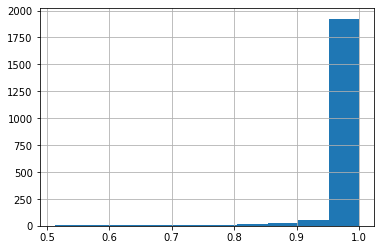

In [21]:
test['confidence score'].hist()

In [22]:
test_true = test.loc[(test.pred == 1) & (test['confidence score'] >= 0.975)].copy()

In [23]:
test_true = test.loc[test.pred == 1].copy()

In [24]:
test_true.shape

(18, 3)

In [25]:
test_true.head(3)

,image_id,pred,confidence score
296,/clean/V1492_2021_0042_001225.png,1,0.848870
303,/clean/V1492_2021_0042_001879.png,1,0.684942
361,/clean/V1492_2021_0042_001227.png,1,0.934809


In [26]:
true_names = test_true.image_id.tolist()

In [27]:
print(len(true_names))

18


In [28]:
from shutil import copyfile
for e in true_names:
    copyfile('/home/super/endo_venv/gsun/blur_classification/inferenced_data' + e, '/Data/data/data_gsun/Cecum/inferenced/cecum/' + e.split('/')[2])

In [29]:
test_false = test.loc[test.pred == 0].copy()

In [30]:
false_names = test_false.image_id.tolist()

In [31]:
from shutil import copyfile
for e in false_names:
    copyfile('/home/super/endo_venv/gsun/blur_classification/inferenced_data' + e, '/Data/data/data_gsun/Cecum/inferenced/non_cecum/' + e.split('/')[2])

In [39]:
test_clean = test.loc[(test.pred == 0) & (test['confidence score'] >= 0.975)].copy()

In [40]:
test_clean.shape

(4037, 3)

In [41]:
test_clean.head(3)

,image_id,pred,confidence score
7,/1732/V1732_00008.png,0,0.985698
16,/1732/V1732_00017.png,0,0.981278
17,/1732/V1732_00018.png,0,0.992170


In [42]:
clean_names = test_clean.image_id.tolist()

In [43]:
names = blur_names + clean_names

In [44]:
print(len(names))

6943


In [45]:
from shutil import copyfile

In [46]:
for i,e in enumerate(names):
    if i < len(blur_names):
        copyfile('/Data/data/blur_detection' + e, '/Data/data/blur_detection/result_1732_blur' + e[5:])
    else:
        copyfile('/Data/data/blur_detection' + e, '/Data/data/blur_detection/result_1732_clean' + e[5:])
# copyfile('/Data/data/blur_detection','C:\\test\\test_copy.txt')

In [86]:
def segger(x):
    y = None
    if type(x) == str:
        xx = x.split('/')[-1]
        if 'AC' in xx:
            y = 'AC'
        elif 'TC' in xx:
            y = 'TC'
        elif 'DC' in xx:
            y = 'DC'
        elif 'SC' in xx:
            y = 'SC'
        elif 'Rec' in xx:
            y = 'Rectum'
        else:
            y = 'Cecum'
            
    return y

In [116]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
#test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.81505
[[1484  376]
 [  54  411]]


In [117]:
test.head(5)

,image_id,label,pred,confidence score,segment
0,/cecum/V0246_2020_0016_001613.png,1,1,0.960615,Cecum
1,/cecum/V0246_2020_0016_001435.png,1,1,0.998785,Cecum
2,/cecum/V0246_2020_0016_001430.png,1,1,0.997008,Cecum
3,/cecum/V0246_2020_0016_001425.png,1,1,0.999448,Cecum
4,/cecum/V0244_2020_0014_001780.png,1,1,0.961064,Cecum


In [118]:
test['segment'] = test['image_id'].apply(segger)

In [119]:
test.head(10)

,image_id,label,pred,confidence score,segment
0,/cecum/V0246_2020_0016_001613.png,1,1,0.960615,Cecum
1,/cecum/V0246_2020_0016_001435.png,1,1,0.998785,Cecum
2,/cecum/V0246_2020_0016_001430.png,1,1,0.997008,Cecum
3,/cecum/V0246_2020_0016_001425.png,1,1,0.999448,Cecum
4,/cecum/V0244_2020_0014_001780.png,1,1,0.961064,Cecum
5,/cecum/V0244_2020_0014_001709.png,1,1,0.977875,Cecum
6,/cecum/V0242_2020_0012_002368.png,1,1,0.997580,Cecum
7,/cecum/V0242_2020_0012_002363.png,1,1,0.907787,Cecum
8,/cecum/V0242_2020_0012_002064.png,1,1,0.997911,Cecum
9,/cecum/V0242_2020_0012_002021.png,1,1,0.999396,Cecum


In [120]:
test_unmatch = test.loc[test['label'] != test['pred']].copy()

In [121]:
test.groupby('segment').size()

segment
Cecum     465
DC        465
Rectum    465
SC        465
TC        465
dtype: int64

In [122]:
test_unmatch.groupby('segment').size()

segment
Cecum      54
DC         88
Rectum    125
SC         79
TC         84
dtype: int64

In [97]:
test.to_csv('test_6th_epoch_1.csv')

In [30]:
unmatch_names = test_unmatch['image_id'].tolist()

In [29]:
from shutil import copyfile
for e in unmatch_names:
    copyfile('test_data/V0672_p1_SSL' + e, 'inferenced_data/3rd_epoch_48/V0672_p1_SSL' + e)

In [ ]:
!kill -9 3181316

In [43]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
#test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.95745
[[122  10]
 [  2 148]]


In [44]:
test[test.pred == 1]

,image_id,label,pred
0,/blur_1732/V1732_09834.png,1,1
1,/blur_1732/V1732_09835.png,1,1
2,/blur_1732/V1732_09836.png,1,1
3,/blur_1732/V1732_09805.png,1,1
5,/blur_1732/V1732_09806.png,1,1
...,...,...,...
105,/clean_1732/V1732_01843.png,0,1
106,/clean_1732/V1732_01841.png,0,1
107,/clean_1732/V1732_01835.png,0,1
108,/clean_1732/V1732_01834.png,0,1


In [52]:
test['Conf_scroe']=np.max(tst_preds, axis=1)

In [47]:
import shutil

In [49]:
for image in test[test.pred == 0].image_id.values :
    shutil.copy('/mnt/d/@diagnosis/NBI_same/'+image, '/mnt/d/@diagnosis/NBI_same_0/'+image)
    #print(image)

In [54]:
test.to_csv('iq.csv',index=False)

In [42]:
# train
train_ = train.loc[trn_idx,:]
train_['pred'] = np.argmax(trn_preds, axis=1)

trn_acc = (train_.label.values==np.argmax(trn_preds, axis=1)).mean()
trn_matrix = confusion_matrix(train_['label'], train_['pred'])
print(round(trn_acc, 5))
print(trn_matrix)

0.98007
[[ 880   29]
 [  12 1136]]


In [43]:
train_.label.value_counts()

1    1148
0     909
Name: label, dtype: int64

In [44]:
# valid
valid_['pred'] = np.argmax(val_preds, axis=1)

# np.sum(train.label == train.pred) / len(train)
val_acc = (valid_.label.values==np.argmax(val_preds, axis=1)).mean()
val_matrix = confusion_matrix(valid_['label'], valid_['pred'])
print(round(val_acc, 5))
print(val_matrix)

0.97476
[[222   6]
 [  7 280]]


In [52]:
# test
# test['label'] = test['image_id'].apply(lambda x : 0 if 'cancer' in x else 1)
test['pred'] = np.argmax(tst_preds, axis=1)
test['confidence score'] =np.max(tst_preds, axis=1)
test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
print(round(test_acc, 5))
print(test_matrix)

0.97356
[[ 121   11]
 [  29 1352]]


In [98]:
def score(df):
    TP=len(df.query("label==1 and pred==1 "))
    TN=len(df.query("label==0 and pred==0 "))
    FP=len(df.query("label==0 and pred==1 "))
    FN=len(df.query("label==1 and pred==0 "))
    Sen=round(TP/(TP+FN),4)
    Spe=round(TN/(TN+FP),4) if TN+FP != 0 else 0
    PPV=round(TP/(TP+FP),4)
    NPV=round(TN/(TN+FN),4) if TN+FN != 0 else 0
    ACC=round((TP+TN)/(TP+TN+FP+FN),4)
    print("TP:",TP)
    print("FP:",FP)
    print("TN:",TN)
    print("FN:",FN)
    print("Sen:",Sen)
    print("Spe:",Spe)
    print("PPV:",PPV)
    print("NPV:",NPV)
    print("ACC:",ACC)

In [47]:
score(train_)

TP: 1136
FP: 29
TN: 880
FN: 12
Sen: 0.9895
Spe: 0.9681
PPV: 0.9751
NPV: 0.9865
ACC: 0.9801


In [48]:
score(valid_)

TP: 280
FP: 6
TN: 222
FN: 7
Sen: 0.9756
Spe: 0.9737
PPV: 0.979
NPV: 0.9694
ACC: 0.9748


In [123]:
score(test)

TP: 411
FP: 376
TN: 1484
FN: 54
Sen: 0.8839
Spe: 0.7978
PPV: 0.5222
NPV: 0.9649
ACC: 0.8151


In [55]:
test

,image_id,label,pred,confidence score
0,/blur_1732/V1732_09834.png,1,1,0.999997
1,/blur_1732/V1732_09835.png,1,1,1.000000
2,/blur_1732/V1732_09836.png,1,1,0.999225
3,/blur_1732/V1732_09805.png,1,1,1.000000
4,/blur_1732/V1732_09804.png,1,1,0.999984
...,...,...,...,...
127,/clean_1732/V1732_00899.png,0,0,0.997530
128,/clean_1732/V1732_00898.png,0,0,0.999677
129,/clean_1732/V1732_00897.png,0,0,0.999659
130,/clean_1732/V1732_00896.png,0,0,0.998792


In [60]:
test.to_csv("blur_classification_model_106_21_test_1732.xlsx",index=False)

## Roc Score, Precision, Recal

In [56]:
from sklearn.metrics import *

In [31]:
def softmax(x):
    
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    
    print('accuracy: {0:.5f}, roc_auc: {1:.5f}, precision: {2:.5f}, recall: {3:.5f}, f1: {4:.5f}'.format(
         accuracy, roc_auc, precision, recall, f1))

In [52]:
train_eval = get_clf_eval(train_.label, pred=train_.pred, pred_proba=softmax(trn_preds)[:, 1])
train_eval

Confusion Matrix
[[ 880   29]
 [  12 1136]]
accuracy: 0.98007, roc_auc: 0.99743, precision: 0.97511, recall: 0.98955, f1: 0.98227


In [53]:
valid_eval = get_clf_eval(valid_.label, pred=valid_.pred, pred_proba=softmax(val_preds)[:, 1])
valid_eval

Confusion Matrix
[[222   6]
 [  7 280]]
accuracy: 0.97476, roc_auc: 0.99621, precision: 0.97902, recall: 0.97561, f1: 0.97731


In [32]:
test_eval = get_clf_eval(test.label, pred=test.pred, pred_proba=softmax(tst_preds)[:, 1])
test_eval

NameError: name 'accuracy_score' is not defined